# tSNE for figure and general exploration
# heatmaps for disease and general exploration

In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets
from sklearn import decomposition
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import plot_confusion_matrix
from pathlib import Path
import os
import matplotlib.pyplot as plt
#import cupy as np
#import gnumpy as gpu
import numpy as np
from catboost import CatBoost
from sklearn import preprocessing
from catboost.utils import eval_metric
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import pickle
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

### Normalize the data: fill nan, filter out any biomes < k counts


In [2]:
def read_in_data_filter_integer_labels(grouped = 30,
                        csv = "/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/copy_number_abundance.csv"):
    df = pd.read_csv(csv)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.fillna(0)

    grouped_df = df.groupby('biome').filter(lambda x : len(x) > grouped)
    grouped_df = grouped_df.reset_index(drop=True)
    print(grouped_df['biome'].nunique())

    
    # drop constant columns
    print(grouped_df.shape)
    # record columns to delete
    counts = grouped_df.nunique()
    to_del = [i for i,v in enumerate(counts) if v == 1]
    print('constant columns: ',to_del)
    # drop useless columns
    grouped_df.drop(grouped_df.columns[[to_del]],axis = 1, inplace=True)
    print(grouped_df.shape)
    
    le = preprocessing.LabelEncoder()
    le.fit(grouped_df.biome)
    #list(le.classes_)
    le.transform(grouped_df.biome)
    
    return grouped_df, le

In [4]:
g, le = read_in_data_filter_integer_labels(grouped=0)

78
(16223, 14992)
constant columns:  []


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(16223, 14992)


# For gut heatmap graphs

In [7]:
g = g[g.biome.str.contains("Host-associated:Mammals: Human:Large intestine")]
g = g.loc[~(g.sum(axis=1) == 0),~(g.sum(axis=0) == 0)]
g=g.reset_index(drop=True)

GOLD = g['GOLD Analysis Project ID']
g=g.drop(['biome','GOLD Analysis Project ID'],axis=True)
g = g.loc[~(g.sum(axis=1) == 0),~(g.sum(axis=0) == 0)]

corr_matrix = g.corr()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [11]:
#log_test=group_df_transposed_test.drop('bar',axis=1)
log_test = np.log2(g.drop(['biome','GOLD Analysis Project ID'],axis=1))
log_test.replace([np.inf, -np.inf], np.nan, inplace=True)
log_test.fillna(0.0, inplace=True)
log_test = log_test.loc[:,~(log_test.sum(axis=0) == 0)]
#log_test[['72684.0']]

g['72684.0'].corr(g['111724.0'])
corr_matrix[corr_matrix[['16225.0']]<-.2]['16225.0']

divide by zero encountered in log2


In [58]:
f = g_copy[['16225.0','biome']]
f = f[f['16225.0'] > 0]
f.biome.value_counts()

Host-associated:Mammals: Human:Large intestine    909
Environmental:Terrestrial:Wetlands                128
Environmental:Terrestrial:Insects nest            116
Environmental:Aquatic:Lake                         97
Engineered:Bioreactor:Unclassified                 87
                                                 ... 
Environmental:Aquatic:Lentic                        1
Environmental:Terrestrial:Glacier                   1
Host-associated:Plants:Phylloplane/Leaf             1
Environmental:Terrestrial:Watershed                 1
Environmental:Terrestrial:Litterfall                1
Name: biome, Length: 64, dtype: int64

In [9]:
g = g.loc[:,~(g.sum(axis=0) == 0)]

In [8]:
# adding other labels
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD
h.head()

g = g.merge(h[['GOLD Analysis Project ID', 'Disease']], on='GOLD Analysis Project ID', how='left')

Columns (15,17,29,30) have mixed types. Specify dtype option on import or set low_memory=False.


In [12]:
g= g.drop(['biome', 'GOLD Analysis Project ID'],axis=1)

In [90]:
a=['112899.0','55998.0','5255.0','8526.0','27946.0','57709.0','16205.0','112837.0', '10655.0',
   '96765.0','66664.0','21148.0','79703.0','15116.0','72684.0', '27001.0']
len(a)

16

#corr_matrix[corr_matrix[['72684.0']]<-.2]['16225.0']
print(g['72684.0'].corr(g['30279.0']))
g['55998.0'].sum()

In [91]:
list_anticorrelated = pd.DataFrame()
for bar in a:
    just_qceb = corr_matrix[[bar]]#, '111724.0']]
    list_anticorrelated = list_anticorrelated.append(pd.DataFrame(just_qceb[just_qceb[bar]>0.9].reset_index()['index']))
list_anticorrelated = list_anticorrelated.drop_duplicates()
a = a + list(list_anticorrelated['index'])
print(a)
list_anticorrelated = pd.DataFrame()

for bar in a:
    just_qceb = corr_matrix[[bar]]#, '111724.0']]
  #  just_qceb_x = just_qceb[just_qceb['72684.0']>0.80]
   # just_qceb = just_qceb[just_qceb[bar]<-0.2]
   # print(bar, pd.DataFrame(just_qceb[just_qceb[bar]<-0.2].reset_index()['index']))
    list_anticorrelated = list_anticorrelated.append(pd.DataFrame(just_qceb[just_qceb[bar]<-0.2].reset_index()['index']))
list_anticorrelated = list_anticorrelated.drop_duplicates()
a = a + list(list_anticorrelated['index'])

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

['112899.0', '55998.0', '5255.0', '8526.0', '27946.0', '57709.0', '16205.0', '112837.0', '10655.0', '96765.0', '66664.0', '21148.0', '79703.0', '15116.0', '72684.0', '27001.0', '53807.0', '55998.0', '8526.0', '112899.0', '57709.0', '5255.0', '27001.0', '27946.0', '112837.0', '16205.0', '10655.0', '96765.0', '24802.0', '72684.0', '66664.0', '21148.0', '79703.0', '15116.0']


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

In [525]:
len(a)
a.remove('91432.0')
a_2 = a + ['GOLD']

In [526]:
# names of the HKs
trying = g[g.columns.intersection(a)]
#trying=g.drop('GOLD', axis=1)

f=trying.transpose()
f=f.loc[:,~(f.sum(axis=0) == 0)]

index_matrix = pd.DataFrame(f.reset_index()['index'])
index_matrix['bar'] = index_matrix['index'].str[:-2]

annotated_bar['bar'] = annotated_bar.bar.apply(str)
index_matrix = index_matrix.merge(annotated_bar[['bar','Short_name']].drop_duplicates(), on='bar', how='left')

index_matrix['Short_name'] = index_matrix.Short_name.fillna(index_matrix['bar'])

## infants heatmap


In [527]:
trying_2 = g[g.columns.intersection(a_2)]
f_2=trying_2.transpose()
f_2=f_2.loc[:,~(f_2.drop('GOLD').sum(axis=0) == 0)]
f_2 = pd.DataFrame(f_2.transpose().GOLD)
f_2 = f_2.merge(h, on='GOLD',how='left')

f_2['infant'] = f_2.Isolation_saved_two.str.contains('infant')
f_2['Newborn'] = f_2.Isolation_saved_two.str.contains('Newborn')
f_2['baby'] = f_2.infant+f_2.Newborn

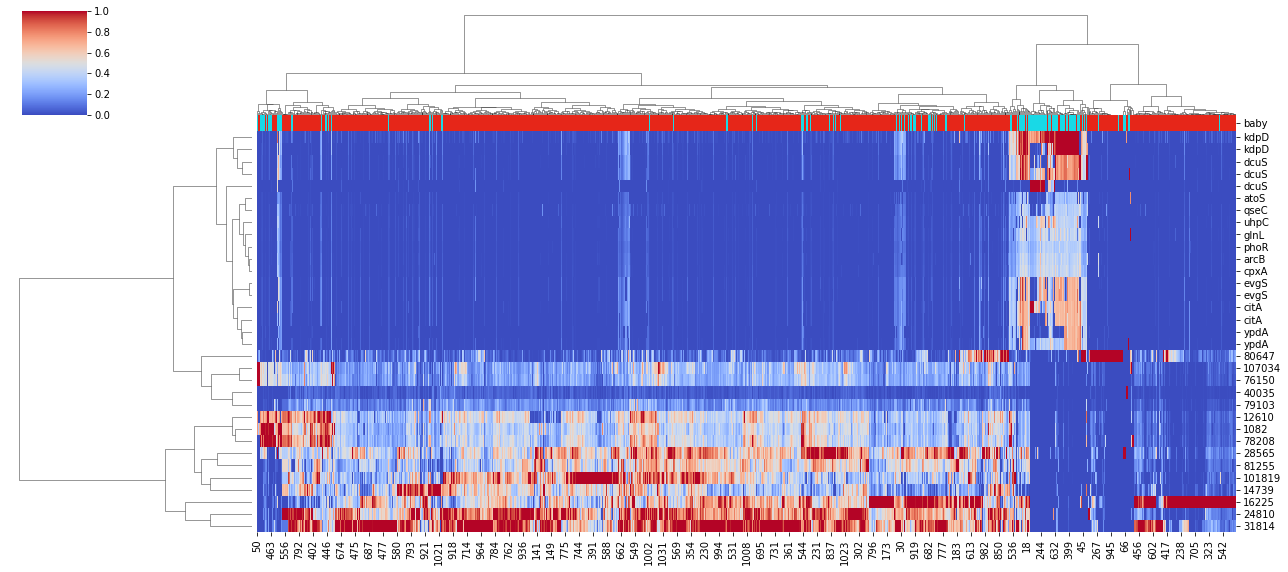

In [532]:
clustergrid_map = sns.clustermap(f.transpose().reset_index(drop=True).transpose(),
               method='ward', 
              # method='single',
             #  metric="correlation",
               yticklabels=index_matrix.Short_name,
               standard_scale=1,
               cmap="coolwarm",figsize=(18,8),
               col_colors=row_colors
              )
clustergrid_map

## disease state heatmap

In [124]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD

g = g.merge(h[['GOLD Analysis Project ID', 'Disease']], on='GOLD Analysis Project ID', how='left')
Disease = g.Disease
g_copy = g.drop(['biome','GOLD Analysis Project ID', 'Disease'], axis=1)

lut = dict(zip(Disease.unique(), sns.hls_palette(len(set(Disease.unique())), l=0.5, s=0.8)))
row_colors = Disease.map(lut)


Columns (15,17,29,30) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
trying = g[g.columns.intersection(a)]
trying=trying.loc[~(trying.sum(axis=1) == 0),~(trying.sum(axis=0) == 0)]
trying

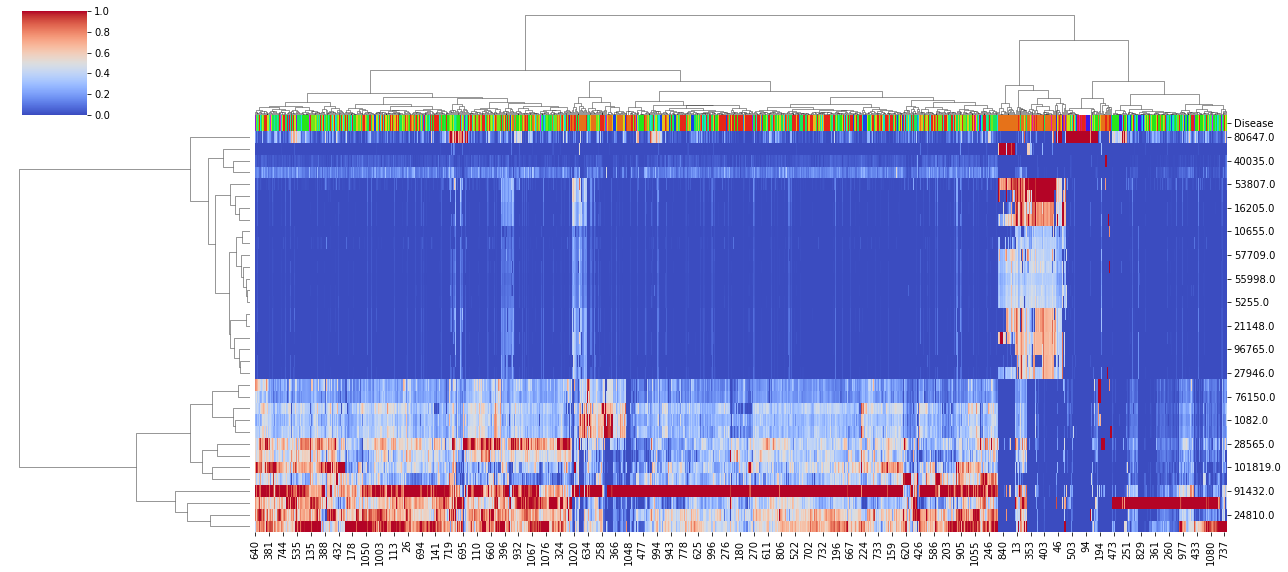

In [102]:
clustergrid_map = sns.clustermap(trying.transpose(),
               method='ward', 
              # method='single',
             #  metric="correlation",
              # yticklabels=index_matrix.Short_name,
               standard_scale=1,
               cmap="coolwarm",figsize=(18,8),
               col_colors=row_colors
              )
clustergrid_map

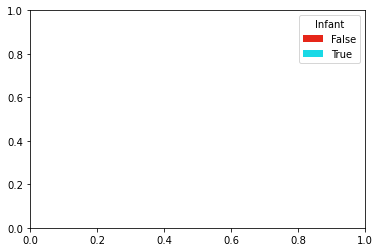

In [530]:
from matplotlib.patches import Patch 
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Infant',)

In [311]:
samples = f[f.columns.intersection(columns_map)]
samples.style.background_gradient(cmap='coolwarm')

In [312]:
index_matrix

,index,bar,Short_name
0,55998.0,55998,phoR
1,8526.0,8526,glnL
2,16205.0,16205,dcuS
3,79703.0,79703,ypdA
4,112899.0,112899,arcB
5,10655.0,10655,atoS
6,66664.0,66664,evgS
7,57709.0,57709,uhpC
8,15116.0,15116,dcuS
9,96765.0,96765,citA


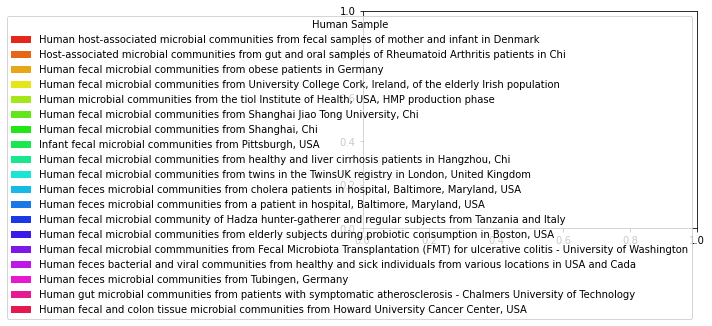

In [ ]:
#

In [21]:
#pca
def PCA_script(df, transpose = False, loadings = False, pcs=3):
    #convert to matrix
    matrix = df.to_numpy()
    
    if transpose:
        matrix = matrix.T
    #run decomposision
    pca = decomposition.PCA(n_components=pcs)
    pca.fit(matrix)
    #interpretation: as go from 1 -> n'th PC, how much of data can you explain?
    print(pca.singular_values_)
    print(pca.explained_variance_ratio_)
    # make a plot to analyze. could also use results for ML application here.
    if loadings: #returns to analyze and also returns the loadings for each variable
        return(pca.transform(matrix), pca.components_.T * np.sqrt(pca.explained_variance_))
        
    return(pca.transform(matrix))

# Tsne

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=5 in 5.5 sec


The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=15 in 5.8 sec


The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=30 in 7.8 sec


The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=100 in 11 sec


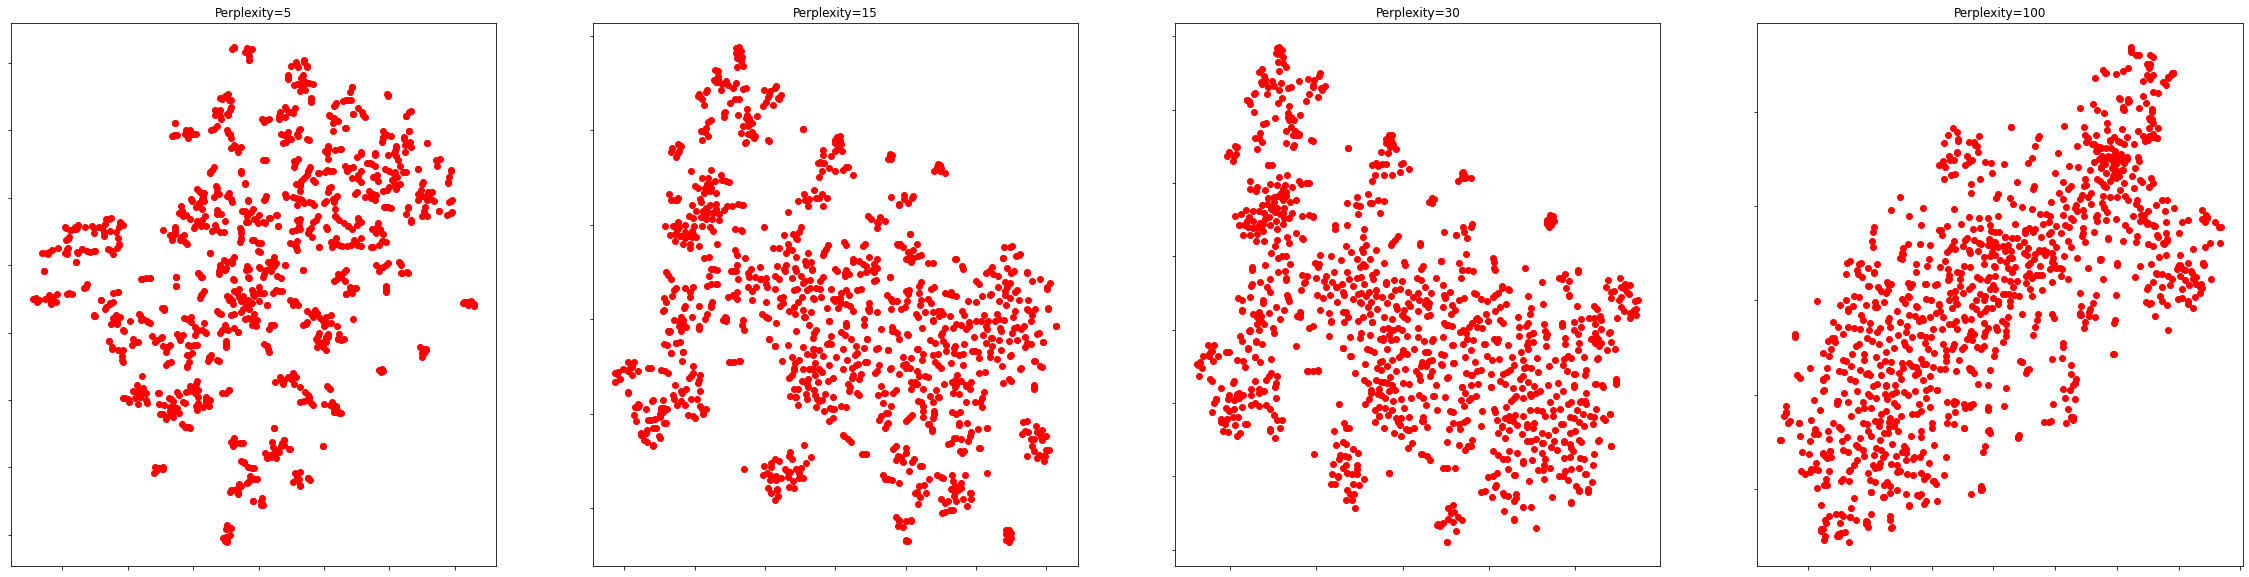

In [39]:
# all biomes
f_copy = g
X = f_copy

n_components = 2
(fig, subplots) = plt.subplots(1, 4, figsize=(40, 10), squeeze=False)
perplexities = [5,15,30,100]#, 100]


for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i]
    
    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        #learning_rate="auto",
        n_iter=1000,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    #X_2d[y == i, 0], X_2d[y == i, 1]
    ax.scatter(Y[:,0], Y[:,1], c="r")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

plt.show()

In [93]:
f_copy.biome.value_counts()
df = pd.DataFrame(Y)
df['biome'] = f_copy.reset_index(drop=True).biome
df.columns = ['X','Y','biome']

alt.Chart(df.sample(5000), height=400, width=500).mark_circle(size=60).encode(x='Y',y='X',
                                    color='biome',tooltip='biome')

alt.Chart(...)

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=3 in 0.32 sec


The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=5 in 0.26 sec


The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=10 in 0.27 sec


The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


perplexity=15 in 0.28 sec


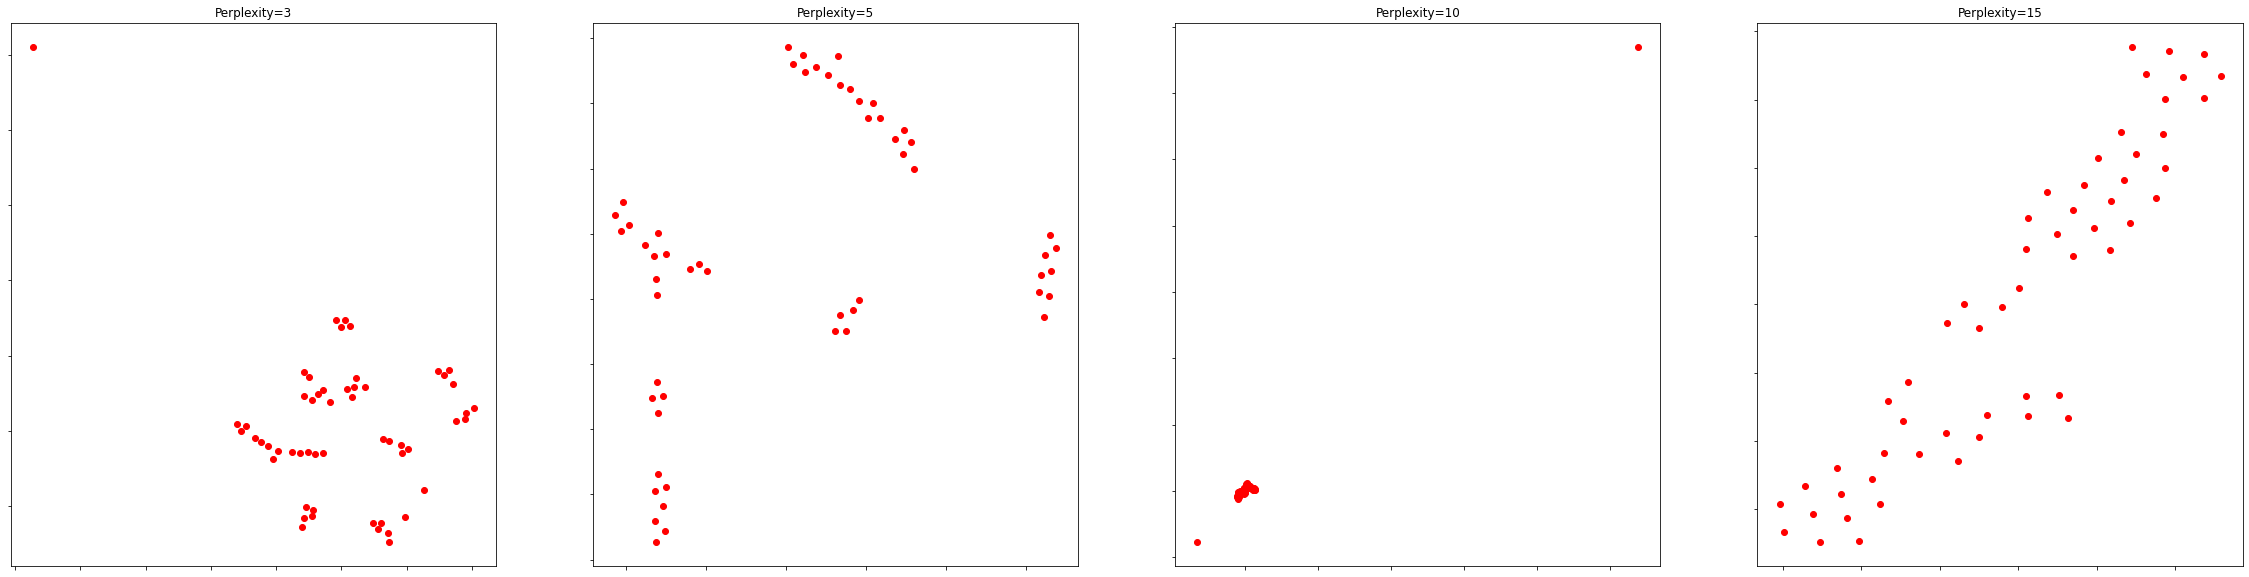

In [167]:
# Vagina
f_copy = g
X = f_copy

n_components = 2
(fig, subplots) = plt.subplots(1, 4, figsize=(40, 10), squeeze=False)
perplexities = [3,5,10,15]#, 100]


for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i]
    
    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        #learning_rate="auto",
        n_iter=1000,
    )
    Y = tsne.fit_transform(X)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    #X_2d[y == i, 0], X_2d[y == i, 1]
    ax.scatter(Y[:,0], Y[:,1], c="r")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

plt.show()

In [171]:
df = pd.DataFrame(Y)

df['biome'] = GOLD#f_copy.reset_index(drop=True).biome
df['Hospital_Visits'] = f_2.Hospital_Visits
df.columns = ['X','Y','biome', 'Hospital_Visits']
base = alt.Chart(df, height=200, width=200).mark_circle(size=60).encode(x='Y',y='X',
                                    color='Hospital_Visits',tooltip='Hospital_Visits')
alt.vconcat(

   base.encode(color='Hospital_Visits:N').properties(title='nominal'),
)

alt.VConcatChart(...)

# Human biomes

circles, perplexity=50 in 11 sec


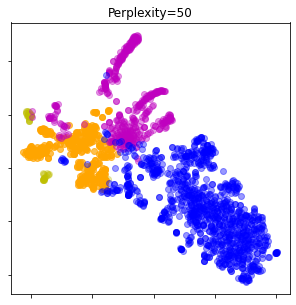

In [40]:
host_index = f_copy['biome'].str.contains('Large intestine')
env_index = f_copy['biome'].str.contains('Skin')
eng_index = f_copy['biome'].str.contains('Oral cavity')
human_index = f_copy['biome'].str.contains('Vagina')


#for i in range(1,host_index.size):
#    if(host_index[i] and human_index[i]):
#        host_index[i] = False


(fig, subplots) = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)

perpl = 500
ax = subplots[0][0]

print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
ax.set_title("Perplexity=%d" % perplexity)
#X_2d[y == i, 0], X_2d[y == i, 1]

ax.scatter(Y[human_index,0], Y[human_index,1], c="y", alpha=0.3)
ax.scatter(Y[eng_index,0], Y[eng_index,1], c="orange", alpha=0.7)
ax.scatter(Y[env_index,0], Y[env_index,1], c="m", alpha=0.4)
ax.scatter(Y[host_index,0], Y[host_index,1], c="b", alpha=0.4)

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")


plt.show()

# Just human gut biomes
* label qseCB when the heatmap identified the clusters

In [112]:
from sklearn.manifold import TSNE
X = g.loc[:,~(g.sum(axis=0) == 0)]
X = X.transpose()
X_2d = TSNE(n_components=2, perplexity=30.0, n_iter=5000, verbose=1).fit_transform(X)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1707 samples in 0.001s...
[t-SNE] Computed neighbors for 1707 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1707
[t-SNE] Computed conditional probabilities for sample 1707 / 1707
[t-SNE] Mean sigma: 0.000067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.012894
[t-SNE] KL divergence after 5000 iterations: 1.348608


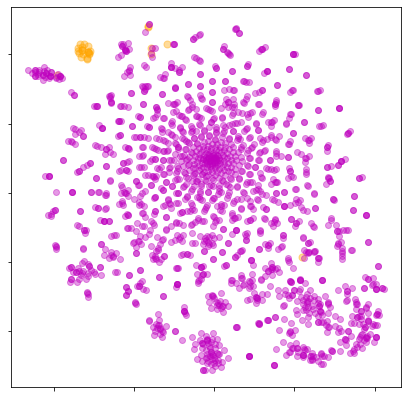

In [72]:
(fig, subplots) = plt.subplots(1, 1, figsize=(7, 7), squeeze=False)

perpl = 500
ax = subplots[0][0]
#X_2d[y == i, 0], X_2d[y == i, 1]

#ax.scatter(Y[human_index,0], Y[human_index,1], c="y", alpha=0.3)
#ax.scatter(Y[eng_index,0], Y[eng_index,1], c="orange", alpha=0.7)
ax.scatter(host_index['tsne-2d-one'], host_index['tsne-2d-two'], c="orange", alpha=0.4, s=50)
ax.scatter(env_index['tsne-2d-one'], env_index['tsne-2d-two'], c="m", alpha=0.4)

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")


plt.show()

In [54]:
pca_50 = decomposition.PCA(n_components=30)
X = g.loc[:,~(g.sum(axis=0) == 0)]
X = X.transpose()
pca_result_50 = pca_50.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
tsne_pca_results = manifold.TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000).fit_transform(X)

Cumulative explained variation for 50 principal components: 0.8857702048535718
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1707 samples in 0.001s...
[t-SNE] Computed neighbors for 1707 samples in 0.145s...


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


[t-SNE] Computed conditional probabilities for sample 1000 / 1707
[t-SNE] Computed conditional probabilities for sample 1707 / 1707
[t-SNE] Mean sigma: 0.000067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.164825
[t-SNE] KL divergence after 1000 iterations: 1.359008


circles, perplexity=100 in 11 sec


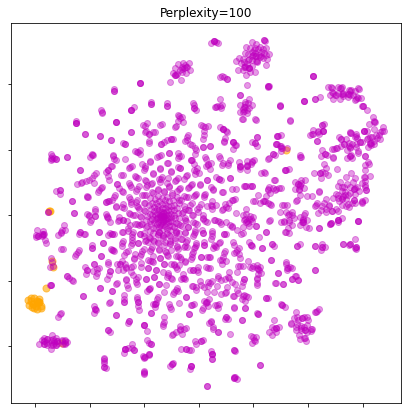

In [56]:
host_index = index_matrix[index_matrix['size']>6]
env_index = index_matrix[index_matrix['size']==5]

(fig, subplots) = plt.subplots(1, 1, figsize=(7, 7), squeeze=False)

perpl = 500
ax = subplots[0][0]

print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
ax.set_title("Perplexity=%d" % perplexity)
#X_2d[y == i, 0], X_2d[y == i, 1]

#ax.scatter(Y[human_index,0], Y[human_index,1], c="y", alpha=0.3)
#ax.scatter(Y[eng_index,0], Y[eng_index,1], c="orange", alpha=0.7)
ax.scatter(host_index['tsne-2d-one'], host_index['tsne-2d-two'], c="orange", alpha=0.6, s=50)
ax.scatter(env_index['tsne-2d-one'], env_index['tsne-2d-two'], c="m", alpha=0.4)

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")


plt.show()

In [245]:
index_matrix.to_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/index_matrix.csv')